# Selecting policies based on single objective
This is common in literature. Thus, it allows us to judge what impact the choice of the belief update function currently might have.

# Overall Plan:
1. load data (already pre-processed to avg over replications)
2. non-dominated sort of only 1 objective (belief-based obj.) -> select policies
3. parallel axis plots of levers & outcomes (to inspect selected policies)

In [1]:
# Imports
import os
import pandas as pd
from model.enums import BeliefUpdate
from dmdu.utils_dmdu import make_sure_path_exists, get_lever_names
from dmdu.exploration.utils import parcoords_levers, parcoords_outcomes, get_outcome_names
import seaborn as sns
from ema_workbench.analysis import parcoords


## 1. Load data (already pre-processed to avg over replications)

In [2]:
# bufn = BeliefUpdate.DEFFUANT
# select_max = True
# select_n = 20  # only considered if select_max == False

In [3]:
# # Loading the outcomes
# filename = "outcomes" + f"_{bufn.name}.csv"
# outcomes_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", "input", filename)
# outcomes = pd.read_csv(outcomes_path)
#
# # Loading experiments
# filename = "experiments" + f"_{bufn.name}.csv"
# experiments_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", "input", filename)
# experiments = pd.read_csv(experiments_path)

## 2. non-dominated sort of only 1 objective (belief-based obj.) -> select policies

### Select policies based on outcomes, save to .csv

In [4]:
# # Careful: only does it now for 1 bufn, 1 select_max, 1 select_n. Not yet like below (for loops)
#
# # Sort outcomes based on o1 (n_agents_above_belief_threshold)
# if select_max:
#     # Only keep rows with highest entry for o1
#     max_value = outcomes['n_agents_above_belief_threshold'].max()
#     outcomes = outcomes[outcomes["n_agents_above_belief_threshold"] == max_value]
#     dir_name = "max_value"
#
# else:
#     # Only keep first select_n entries
#     outcomes = outcomes.sort_values(by='n_agents_above_belief_threshold', ascending=False)
#     outcomes = outcomes.head(select_n)
#     dir_name = f"{select_n}_best"
#
# # Save outcomes into output directory
# filename = "outcomes" + f"_{bufn.name}.csv"
# dir_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", f"output_{dir_name}")
# make_sure_path_exists(dir_path)
#
# outcomes_path = os.path.join(dir_path, filename)
# outcomes.to_csv(outcomes_path)



### Get corresponding policies (experiments df with lever values), save to .csv

In [5]:
# Already saved the data. Don't need this currently.

# # Subset experiments to get same idx as in new outcomes
# bufns = list(BeliefUpdate)
#
# for bufn in bufns:
#     # load experiments data (all policies)
#     exp_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", "input", f"experiments_{bufn.name}.csv")
#     experiments = pd.read_csv(exp_path)
#
#     for way_of_selecting in [f'{select_n}_best', 'max_value']:
#         # get idx that should be kept
#         out_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", f"output_{way_of_selecting}", f"outcomes_{bufn.name}.csv")
#         outcomes = pd.read_csv(out_path)
#         column_headers = outcomes.columns
#         idx_header = column_headers[0]
#         pareto_idx = [x for x in outcomes[idx_header]]
#
#         # subset experiments
#         subset_exp = experiments[experiments[idx_header].isin(pareto_idx)]
#
#         # save experiments (to .csv in output folder)
#         filename = f"experiments_{bufn.name}.csv"
#         dir_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", f"output_{way_of_selecting}")
#         make_sure_path_exists(dir_path)
#         path = os.path.join(dir_path, filename)
#         subset_exp.to_csv(path)


In [6]:
# Setting up experiments_dict and outcomes_dict (from previously created .csv files)

bufns = list(BeliefUpdate)

experiments_dict = {}
outcomes_dict = {}

for bufn in bufns:

    # Loading the experiments and outcomes
    exp_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", "output_max_value", f"experiments_{bufn.name}.csv")
    experiments = pd.read_csv(exp_path)

    out_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", "output_max_value", f"outcomes_{bufn.name}.csv")
    outcomes = pd.read_csv(out_path)
    outcomes = outcomes[get_outcome_names()]

    # Experiments: Rescale lever values (*10 -> (0-10 -> 0-100, 0-5 -> 0-50))
    lever_names = get_lever_names()
    for col_name in experiments.columns:
        if col_name in lever_names:
            experiments[col_name] *= 10

    # Outcomes: Already averaged over replications (for each scenario)

    # No saving needed, just create experiments_dict and outcomes_dict
    experiments_dict[bufn.name] = experiments
    outcomes_dict[bufn.name] = outcomes


## 3. parallel axis plots of levers & outcomes

In [7]:
sns.set(rc={'figure.figsize': (7, 5)})

# Assign each unique model a color
model_names = [x.name for x in list(BeliefUpdate)]
model_colors = {}
colors = ["darkorange", "blue", "limegreen"]
alpha = 0.15


for _, (model, color) in enumerate(zip(model_names, colors)):
    # w/ color palette: zip(model_names, sns.color_palette("colorblind"))
    model_colors[model] = (color, alpha)

### a) Policies selected

#### DEFFUANT

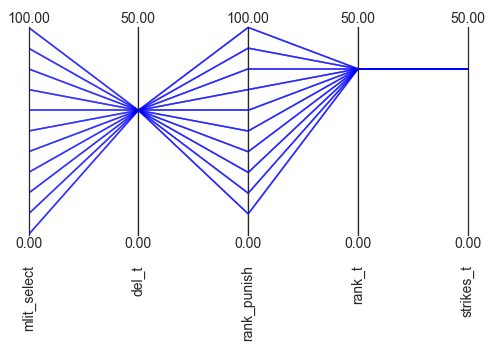

In [8]:
bufn = BeliefUpdate.DEFFUANT
parcoords_levers(experiments_dict, bufn, model_colors)

#### SAMPLE

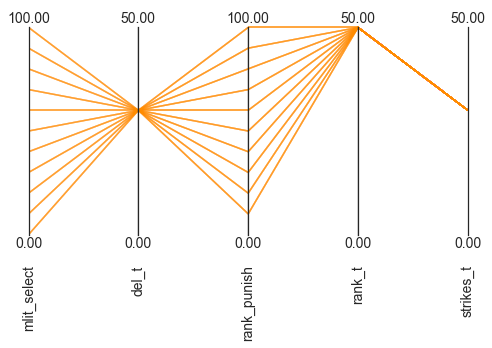

In [9]:
bufn = BeliefUpdate.SAMPLE
parcoords_levers(experiments_dict, bufn, model_colors)

#### SIT

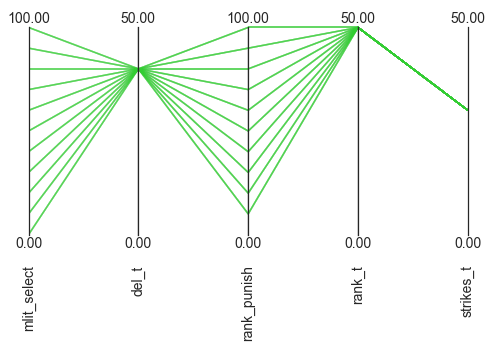

In [10]:
bufn = BeliefUpdate.SIT
parcoords_levers(experiments_dict, bufn, model_colors)

##### Combined

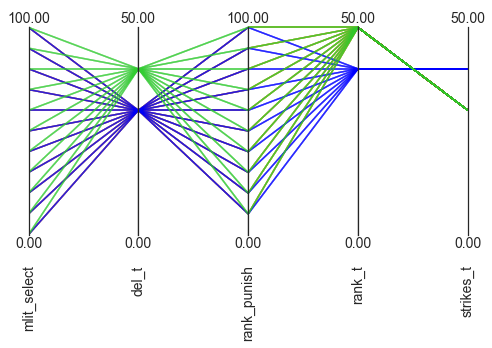

In [11]:
concat_exp = pd.concat(experiments_dict.values())

# Get limits from input (-> not only Pareto-optimal policies, but all)
exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_DEFFUANT.csv")
# doesn't matter which bufn loaded above, all evaluated the same policies
all_exp = pd.read_csv(exp_path)
only_levers = all_exp[get_lever_names()]
exp_limits = parcoords.get_limits(only_levers)

# plot
axes = parcoords.ParallelAxes(exp_limits)

for model_name, data in experiments_dict.items():
    color, alpha = model_colors[model_name]

    # subset data
    lever_data = data[get_lever_names()]
    axes.plot(lever_data, color=color, alpha=alpha)


### b) Outcomes of selected Policies

#### DEFFUANT

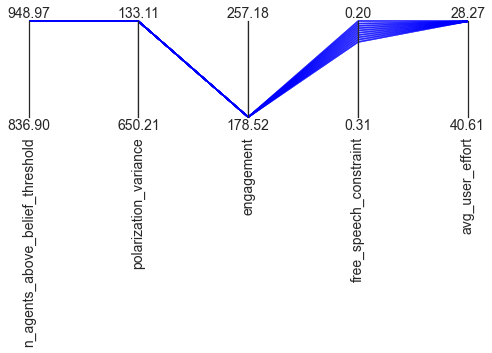

In [12]:
parcoords_outcomes(outcomes_dict, [BeliefUpdate.DEFFUANT], model_colors)

#### SAMPLE

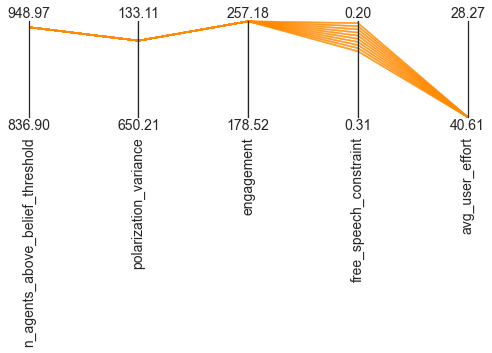

In [14]:
parcoords_outcomes(outcomes_dict, [BeliefUpdate.SAMPLE], model_colors)

#### SIT

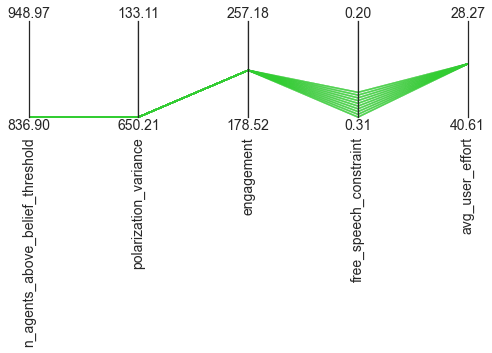

In [15]:
parcoords_outcomes(outcomes_dict, [BeliefUpdate.SIT], model_colors)

#### Combined


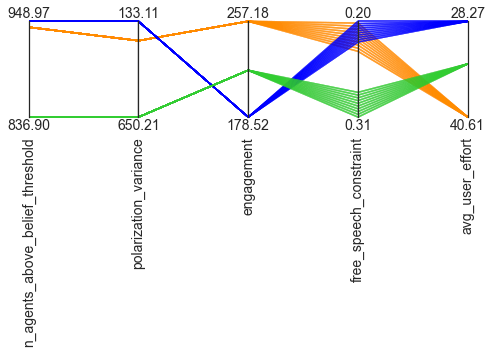

In [16]:
# Get limits
concat_out = pd.concat(outcomes_dict.values())
out_limits = parcoords.get_limits(concat_out)

# Plot
axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)

for bufn in list(BeliefUpdate):
    bufn = bufn.name

    color, alpha = model_colors[bufn]
    axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)

### Compared to performance of all policies (not just to selected ones)

In [ ]:
all_outcomes = {}

for bufn in list(BeliefUpdate):
    # Loading the outcomes
    filename = "outcomes" + f"_{bufn.name}.csv"
    outcomes_path = os.path.join(os.getcwd(), "data", "singleobjectivesort", "input", filename)
    outcomes = pd.read_csv(outcomes_path)
    outcomes = outcomes[get_outcome_names()]

    all_outcomes[bufn.name] = outcomes




# Get limits
concat_out = pd.concat(all_outcomes.values())
out_limits = parcoords.get_limits(concat_out)




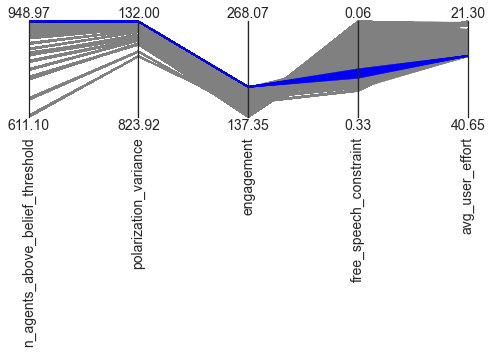

In [20]:
# Plot
axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)

for bufn in [BeliefUpdate.DEFFUANT]:  # list(BeliefUpdate):
    bufn = bufn.name


    color, alpha = model_colors[bufn]

    # first all outcomes
    axes.plot(all_outcomes[bufn], color='grey', alpha=0.03)
    # then selected outcomes
    axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)

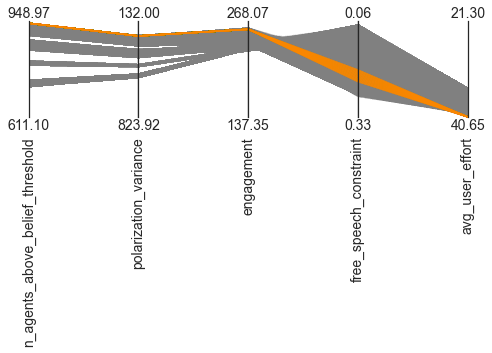

In [21]:
# duplicate code, just briefly to see all three plots without making a function or so
axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)

for bufn in [BeliefUpdate.SAMPLE]:
    bufn = bufn.name


    color, alpha = model_colors[bufn]

    # first all outcomes
    axes.plot(all_outcomes[bufn], color='grey', alpha=0.03)
    # then selected outcomes
    axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)

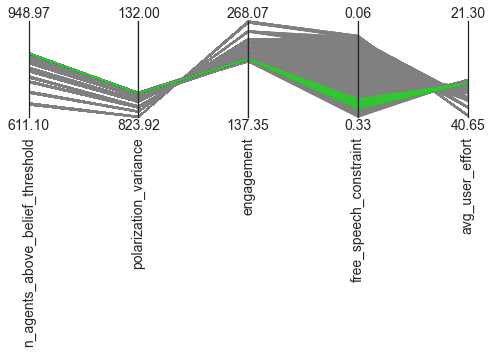

In [22]:
# duplicate code, just briefly to see all three plots without making a function or so
axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)

for bufn in [BeliefUpdate.SIT]:
    bufn = bufn.name


    color, alpha = model_colors[bufn]

    # first all outcomes
    axes.plot(all_outcomes[bufn], color='grey', alpha=0.03)
    # then selected outcomes
    axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)

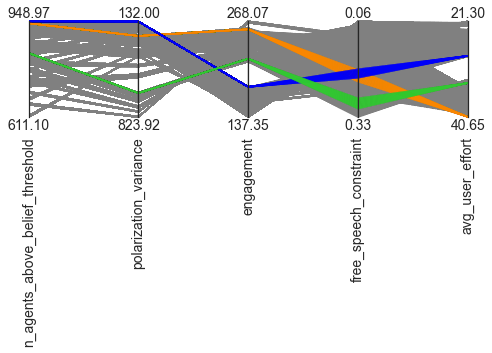

In [24]:
# duplicate code, just briefly to see all three plots without making a function or so
axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)

for bufn in list(BeliefUpdate):
    bufn = bufn.name


    color, alpha = model_colors[bufn]

    # first all outcomes
    axes.plot(all_outcomes[bufn], color='grey', alpha=0.03)
    # then selected outcomes
    # axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)

for bufn in list(BeliefUpdate):
    bufn = bufn.name


    color, alpha = model_colors[bufn]

    # first all outcomes
    # axes.plot(all_outcomes[bufn], color='grey', alpha=0.03)
    # then selected outcomes
    axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)